# Loading Modules

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from utils import view_dataset

In [68]:
f = torch.Tensor([[3,555,4],[3,555,4]])

translation = f[:, 1:].unsqueeze(2)
scale = f[:, 0].unsqueeze(1)
scale
scale_mat = torch.cat((scale, scale), 1)
scale_mat
torch.cat((torch.diag_embed(scale_mat), translation), 2)

tensor([[[  3.,   0., 555.],
         [  0.,   3.,   4.]],

        [[  3.,   0., 555.],
         [  0.,   3.,   4.]]])

In [69]:
class STN_128x128(nn.Module):

    def __init__(self):
        super(STN_128x128, self).__init__()

        ## The what pathway
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
        ## The spatial transformer
        self.localization = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.zero_()

        #self.id = nn.Parameter(torch.tensor([[1, 0], [0, 1]], dtype=torch.float), requires_grad=False)

    def stn(self: object, x: torch.Tensor) -> torch.Tensor:

        xs = self.localization(x)
        xs = xs.view(-1, 128 * 4 * 4)
        
        theta = self.fc_loc(xs)

        translation = theta[:, 1:].unsqueeze(2)
        scale = theta[:, 0].unsqueeze(1)
        scale_mat = torch.cat((scale, scale), 1)
        theta = torch.cat((torch.diag_embed(scale_mat), translation), 2)
        
        #theta = theta.view(-1, 2, 3) 
        #theta = torch.cat((self.id.unsqueeze(0).repeat(theta.size(0), 1, 1), theta.unsqueeze(2)), dim=2)
        
        
        grid_size = torch.Size([x.size()[0], x.size()[1], 28, 28])
        grid = F.affine_grid(theta, grid_size)
        x = F.grid_sample(x, grid)

        return x, theta

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # transform the input
        x, _ = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [70]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}


# Exploring the MNIST with where noise parameters

- 128x128 pixel with shift, noise and circular mask

In [71]:
args.offset_max = 40 #like in the paper

In [72]:
args.offset_std = 40
args.contrast = 0.7
transform_big = transforms.Compose([
    RetinaFill(N_pic=args.N_pic),
    WhereShift(args, radius = 8),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf, flexible=True),
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor()
    #FullfieldRetinaWhiten(N_pic=args.N_pic),
    #FullfieldRetinaTransform(Retina(args).retina_transform_vector),
    #FullfieldToFloatTensor(),
    # Normalize(fullfield=True)
    # transforms.Normalize((args.mean,), (args.std,))
])

train_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform_big,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [73]:
data_big, label_big = next(iter(train_loader))

- Let's view a couple of examples

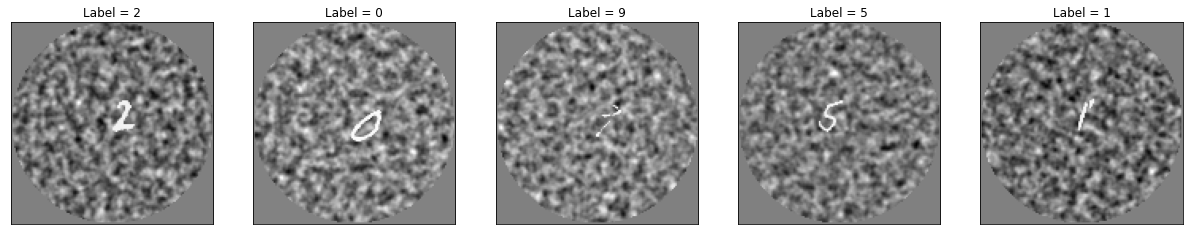

In [74]:
data = view_dataset(train_loader, n=5)

In [75]:
#data.savefig("../figures/data_128x128_noisy_no_shift_.png")

- To replace the first convolutional layer of the spatial transformer network.

# Loading the model

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
#PATH = "../models/stn_128x128.pt"
#model = torch.load(PATH).to(device)
model = STN_128x128().to(device)

In [78]:
def train(epoch, loader):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            output = model(data)

            # sum up batch loss
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            #pred = output.max(1, keepdim=True)[1]
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * correct / len(test_loader.dataset)))
        return correct / len(test_loader.dataset)

# Training parameters of the What/Where model

In [79]:
eccentricities = np.linspace(args.offset_max, 0, 9, endpoint=False)[::-1]
eccentricities

array([ 4.44444444,  8.88888889, 13.33333333, 17.77777778, 22.22222222,
       26.66666667, 31.11111111, 35.55555556, 40.        ])

In [80]:
contrasts = (0.7, 0.5, 0.3)

# Training on contrast 0.7

In [81]:
args.lr

0.005

In [82]:
optimizer = optim.SGD(model.parameters(), lr=args.lr)
loss_func = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1, last_epoch=-1, verbose=True)

In [83]:
for offset in eccentricities[:1]:

    args.contrast = 0.7
    args.offset_std = offset

    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf,
                        flexible=True), 
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor()
    ])
    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform_big,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform_big,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    print("Training on eccentricity=%s" % (offset))
    args.epochs = 20

    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        test(test_loader)

Training on eccentricity=4.444444444444443
Train Epoch: 1/20 [0/60000 (0%)]	Loss: 2.308921
Train Epoch: 1/20 [10000/60000 (17%)]	Loss: 2.300853
Train Epoch: 1/20 [20000/60000 (33%)]	Loss: 2.302101
Train Epoch: 1/20 [30000/60000 (50%)]	Loss: 2.302723
Train Epoch: 1/20 [40000/60000 (67%)]	Loss: 2.300416
Train Epoch: 1/20 [50000/60000 (83%)]	Loss: 2.286602

Test set: Average loss: 0.0230, Accuracy: 1140/10000 (11%)

Train Epoch: 2/20 [0/60000 (0%)]	Loss: 2.295841


KeyboardInterrupt: 

# Training on lesser contrasts

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.00001) # divide another time by 10
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-05.


In [41]:
for contrast in (0.5, 0.3):
    
    print("training on contrast %s" %(contrast))

    args.offset_std = 40 #train while the maximum range is 40
    args.contrast = contrast
    transform_big = transforms.Compose([
        RetinaFill(N_pic=args.N_pic),
        WhereShift(args),
        RetinaBackground(contrast=args.contrast,
                         noise=args.noise,
                         sf_0=args.sf_0,
                         B_sf=args.B_sf),
        RetinaMask(N_pic=args.N_pic),
        transforms.ToTensor()
    ])

    train_loader = torch.utils.data.DataLoader(MNIST('../data',
                            train=True,
                            download=True,
                            transform=transform_big,
                            ),
                            batch_size=args.minibatch_size,
                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST('../data',
                            train=False,
                            download=True,
                            transform=transform_big,
                            ),
                            batch_size=args.minibatch_size,
                            shuffle=True)

    args.epochs = 5
    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader)
        test(test_loader)
        scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-05.
training on contrast 0.5
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.360654
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.176566
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.219222
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.258864
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.265287
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.255012

Test set: Average loss: 0.0018, Accuracy: 9459/10000 (95%)

Adjusting learning rate of group 0 to 1.0000e-05.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.127660
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.279649
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.162196
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 0.200820
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 0.111284
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.123502

Test set: Average loss: 0.0017, Accuracy: 9488/10000 (95%)

Adjusting learning rate of group 0 to 1.0000e-05.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.184512
Train Epoch: 3/10 [10000/6000

Train Epoch: 10/10 [10000/60000 (17%)]	Loss: 0.631529
Train Epoch: 10/10 [20000/60000 (33%)]	Loss: 0.447758
Train Epoch: 10/10 [30000/60000 (50%)]	Loss: 0.553718
Train Epoch: 10/10 [40000/60000 (67%)]	Loss: 0.531397
Train Epoch: 10/10 [50000/60000 (83%)]	Loss: 0.361175

Test set: Average loss: 0.0053, Accuracy: 8391/10000 (84%)

Adjusting learning rate of group 0 to 1.0000e-05.


# Training accuracy

In [2]:
accuracy = [
    0.1135, 0.1135, 0.1317, 0.2374, 0.4015, 0.4956, 0.5147, 0.5731, 0.4378,
    0.8005, 0.8586, 0.8557, 0.9205, 0.9323, 0.9367, 0.946, 0.9479, 0.9464,
    0.9613, 0.9615, 0.8968, 0.9325, 0.9493, 0.9595, 0.9645, 0.9645, 0.9577,
    0.9671, 0.9321, 0.97, 0.9687, 0.9729, 0.9725, 0.9741, 0.9746, 0.9753,
    0.9749, 0.9756, 0.975, 0.9762, 0.9722, 0.9734, 0.9746, 0.9744, 0.9748,
    0.9757, 0.9759, 0.9756, 0.9751, 0.9737, 0.9743, 0.976, 0.9755, 0.9749,
    0.9768, 0.9772, 0.9772, 0.9768, 0.9784, 0.9776, 0.9771, 0.978, 0.9777,
    0.9772, 0.9776, 0.9777, 0.9776, 0.9772, 0.9777, 0.9775, 0.9775, 0.977,
    0.9778, 0.9774, 0.9786, 0.9778, 0.9788, 0.9779, 0.9784, 0.979, 0.9776,
    0.9775, 0.9776, 0.9771, 0.9773, 0.9779, 0.9763, 0.9769, 0.9774, 0.9775,
    0.9459, 0.9488, 0.9510, 0.9533, 0.9523, 0.9563, 0.9563, 0.9549, 0.9573,
    0.9564, 0.7977, 0.8104, 0.8237, 0.8254, 0.8285, 0.8226, 0.8367, 0.8313,
    0.8304, 0.8391
]

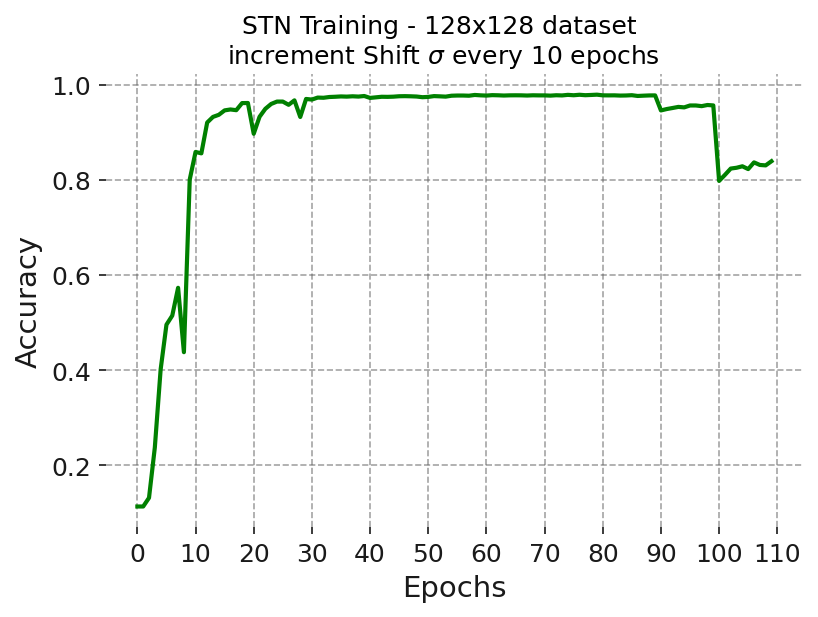

In [5]:
#plt.style.use("gadfly")
fig, ax = plt.subplots(1, 1, dpi=150)
ax.plot(accuracy, 'g')

ax.set_xticks([e for e in range(0, 120, 10)])  
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")

#ax.grid(axis='x', linestyle='--')
fig.suptitle("STN Training - 128x128 dataset \nincrement Shift $\sigma$ every 10 epochs")
#fig.savefig('../figures/acc_training_stn_128x128.png')

# Saving the model trained on all eccentricities and contrasts

In [27]:
final = "../models/atn.pt"
torch.save(model, final)

# Visualizing some results of transformation

In [58]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp
thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:16, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        data = data.type(torch.cuda.FloatTensor)
        
        output_tensor, theta = model.stn(data)
        thetas.append(theta)
        print(output_tensor.shape)

        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor, nrow=4))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor, nrow=4))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        #axarr[0].set_xticks([])
        #axarr[0].set_yticks([])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        #axarr[1].set_xticks([])
        #axarr[1].set_yticks([])
        #f.savefig('../figures/contrast_128x128.png')

torch.Size([16, 1, 28, 28])


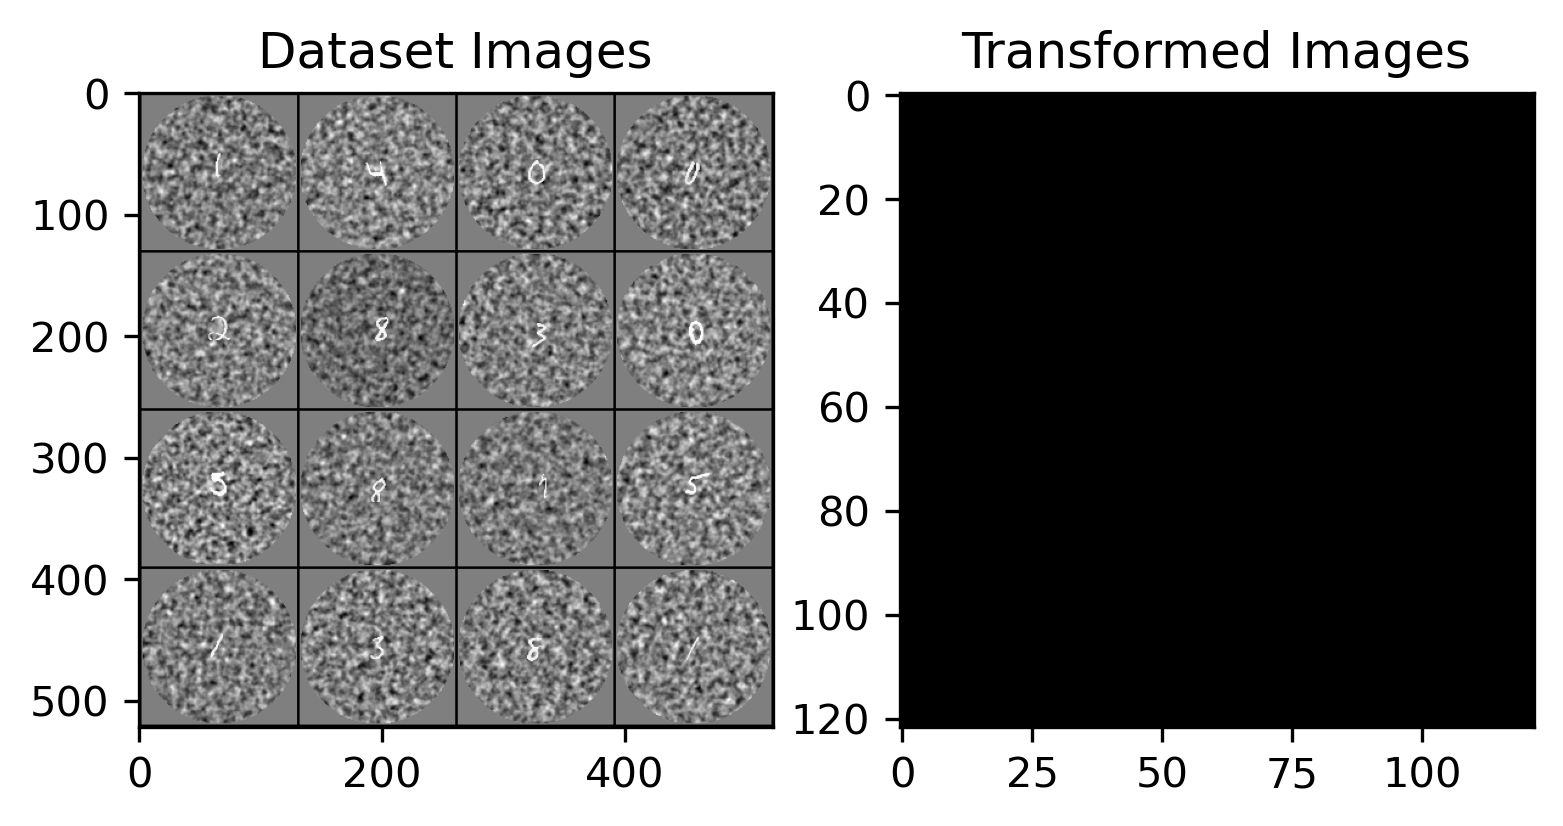

In [59]:
visualize_stn()

In [54]:
thetas

[tensor([[[-0.1947,  0.0000, -0.0049],
          [ 0.0000, -0.1947,  0.0074]],
 
         [[-0.1948,  0.0000, -0.0049],
          [ 0.0000, -0.1948,  0.0074]],
 
         [[-0.1953,  0.0000, -0.0049],
          [ 0.0000, -0.1953,  0.0074]],
 
         [[-0.1944,  0.0000, -0.0048],
          [ 0.0000, -0.1944,  0.0073]],
 
         [[-0.1949,  0.0000, -0.0049],
          [ 0.0000, -0.1949,  0.0074]],
 
         [[-0.1949,  0.0000, -0.0049],
          [ 0.0000, -0.1949,  0.0074]],
 
         [[-0.1959,  0.0000, -0.0050],
          [ 0.0000, -0.1959,  0.0074]],
 
         [[-0.1951,  0.0000, -0.0049],
          [ 0.0000, -0.1951,  0.0074]],
 
         [[-0.1945,  0.0000, -0.0048],
          [ 0.0000, -0.1945,  0.0073]],
 
         [[-0.1942,  0.0000, -0.0048],
          [ 0.0000, -0.1942,  0.0073]],
 
         [[-0.1944,  0.0000, -0.0048],
          [ 0.0000, -0.1944,  0.0073]],
 
         [[-0.1950,  0.0000, -0.0049],
          [ 0.0000, -0.1950,  0.0074]],
 
         [[-0.1945,  0.0000,

# Performance of our STN

- Calculating accuracy in function of eccentricity and contrast for our Spatial transformer network.

In [26]:
stn_stats = {}

for contrast in contrasts:
    print("Testing on contrast = %s"%(contrast))
    
    accuracies = []
    
    for ecc in eccentricities: 

        transform_big = transforms.Compose([
            RetinaFill(N_pic=args.N_pic),
            WhereShift(args, radius = ecc), # given eccentricity
            RetinaBackground(contrast=contrast, # given contrast
                             noise=args.noise,
                             sf_0=args.sf_0,
                             B_sf=args.B_sf, flexible=False), # a fixed contrast
            RetinaMask(N_pic=args.N_pic),
            transforms.ToTensor()
        ])
        train_loader = torch.utils.data.DataLoader(MNIST('../data',
                                train=True,
                                download=True,
                                transform=transform_big,
                                ),
                                batch_size=args.minibatch_size,
                                shuffle=True)

        test_loader = torch.utils.data.DataLoader(MNIST('../data',
                                train=False,
                                download=True,
                                transform=transform_big,
                                ),
                                batch_size=args.minibatch_size,
                                shuffle=True)
        print("Testing on eccentricity = %s"%(ecc))
        acc = test(test_loader)
        accuracies.append(acc)

    stn_stats[contrast] = np.array(accuracies)

Testing on contrast = 0.7
Testing on eccentricity = 4.444444444444443

Test set: Average loss: 0.0009, Accuracy: 9703/10000 (97%)

Testing on eccentricity = 8.888888888888886

Test set: Average loss: 0.0012, Accuracy: 9652/10000 (97%)

Testing on eccentricity = 13.333333333333332

Test set: Average loss: 0.0011, Accuracy: 9632/10000 (96%)

Testing on eccentricity = 17.77777777777778

Test set: Average loss: 0.0012, Accuracy: 9618/10000 (96%)

Testing on eccentricity = 22.22222222222222

Test set: Average loss: 0.0016, Accuracy: 9495/10000 (95%)

Testing on eccentricity = 26.666666666666664

Test set: Average loss: 0.0018, Accuracy: 9433/10000 (94%)

Testing on eccentricity = 31.11111111111111

Test set: Average loss: 0.0026, Accuracy: 9184/10000 (92%)

Testing on eccentricity = 35.55555555555556

Test set: Average loss: 0.0043, Accuracy: 8652/10000 (87%)

Testing on eccentricity = 40.0

Test set: Average loss: 0.0048, Accuracy: 8475/10000 (85%)

Testing on contrast = 0.5
Testing on ecc

In [29]:
stn_stats

{0.7: array([0.9703, 0.9652, 0.9632, 0.9618, 0.9495, 0.9433, 0.9184, 0.8652,
        0.8475]),
 0.5: array([0.9541, 0.9557, 0.9527, 0.9546, 0.9525, 0.9476, 0.9452, 0.9367,
        0.9099]),
 0.3: array([0.5604, 0.5586, 0.5884, 0.6047, 0.6198, 0.5686, 0.4861, 0.3378,
        0.1682])}

# TESTS

In [25]:
accuracies = []

args.offset_std = eccentricities[-1]
args.contrast = 0.3 # contrast will vary between 0.3 and 0.7 during the training

transform_big = transforms.Compose([
    RetinaFill(N_pic=args.N_pic),
    WhereShift(args),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf,
                    flexible=True), # flexible=True for varying contrast
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor()
])
train_loader = torch.utils.data.DataLoader(MNIST(
    '../data',
    train=True,
    download=True,
    transform=transform_big,
),
                                           batch_size=args.minibatch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST(
    '../data',
    train=False,
    download=True,
    transform=transform_big,
),
                                          batch_size=args.minibatch_size,
                                          shuffle=True)

print("Training on eccentricity=%s" % (args.offset_std))
args.epochs = 10

for epoch in range(1, args.epochs + 1):
    train(epoch, train_loader)
    acc = test(test_loader)
    scheduler.step()
    accuracies.append(acc)

Training on eccentricity=40.0
Train Epoch: 1/10 [0/60000 (0%)]	Loss: 0.587256
Train Epoch: 1/10 [10000/60000 (17%)]	Loss: 0.422407
Train Epoch: 1/10 [20000/60000 (33%)]	Loss: 0.624493
Train Epoch: 1/10 [30000/60000 (50%)]	Loss: 0.503047
Train Epoch: 1/10 [40000/60000 (67%)]	Loss: 0.660424
Train Epoch: 1/10 [50000/60000 (83%)]	Loss: 0.505551

Test set: Average loss: 0.0053, Accuracy: 8367/10000 (84%)

Adjusting learning rate of group 0 to 1.0000e-05.
Train Epoch: 2/10 [0/60000 (0%)]	Loss: 0.694104
Train Epoch: 2/10 [10000/60000 (17%)]	Loss: 0.457787
Train Epoch: 2/10 [20000/60000 (33%)]	Loss: 0.573550
Train Epoch: 2/10 [30000/60000 (50%)]	Loss: 0.637762
Train Epoch: 2/10 [40000/60000 (67%)]	Loss: 0.608286
Train Epoch: 2/10 [50000/60000 (83%)]	Loss: 0.754846

Test set: Average loss: 0.0053, Accuracy: 8384/10000 (84%)

Adjusting learning rate of group 0 to 1.0000e-05.
Train Epoch: 3/10 [0/60000 (0%)]	Loss: 0.544703
Train Epoch: 3/10 [10000/60000 (17%)]	Loss: 0.373235
Train Epoch: 3/10 [20